In [1]:
# !pip3 install cryptocompare

In [1]:
%matplotlib inline

import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt
import cryptocompare
import requests
import json
import pandas as pd
import os
from time import sleep
from datetime import datetime
from dotenv import load_dotenv
from mpl_toolkits.mplot3d import Axes3D

load_dotenv()


Bad key "text.kerning_factor" on line 4 in
C:\Users\alexa\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


True

In [52]:
def Main():
    apikey = os.getenv('apikey')
    cryptocompare_api = os.getenv('cryptocompare_api')
    
    def getUserInput():
        prompt = input('Choose profile:\n'
              '1. Binance\n'
              '2. Uniswap\n'
              '3. Gemini\n')
        return int(prompt)

    def getAddress(arg):
        addressBook = {1:'0x3f5CE5FBFe3E9af3971dD833D26bA9b5C936f0bE',
                       2:'0x88599C44e8EeB2Bbc2C1EB4749D37E09c8282d55',
                       3:'0xd24400ae8BfEBb18cA49Be86258a3C749cf46853'}
        return addressBook.get(arg)
    
    def roundNearestMinute(ts):
        return ts.dt.round('1min')
        
    def getPublicKeyTransactions():
        userInput = getUserInput()
        address = getAddress(userInput)

        getAddressTransactions = f'https://api.ethplorer.io/getAddressTransactions/{address}?limit=1000&apiKey={apikey}'
        getAddressTransactionsResponse = requests.get(getAddressTransactions).json()

        timestamp = []
        converted_timestamp = []
        hash_num = []
        value = []
        from_add = []
        to_add = []

        for transaction in getAddressTransactionsResponse:
            timestamp.append(transaction['timestamp'])
            converted_timestamp.append(datetime.fromtimestamp(transaction['timestamp']))
            hash_num.append(transaction['hash'])
            value.append(transaction['value'])
            from_add.append(transaction['from'])
            to_add.append(transaction['to'])

        ts_df = pd.DataFrame({'converted_timestamp':converted_timestamp})
        ts_series = ts_df['converted_timestamp']
        rounded_timestamp = roundNearestMinute(ts_series)
        df = pd.DataFrame({'timestamp': timestamp, 'compare_timestamp': rounded_timestamp, 'transaction_hash': hash_num, 'value_in_eth': value, 'from_address': from_add, 'to_address': to_add})
        return df
    
    def getHistoricalPrice():
        set_crypto_key = f'cryptocompare.cryptocompare._set_api_key_parameter{cryptocompare_api}'
        getHistETHPrice = cryptocompare.get_historical_price_minute('ETH', currency='USD', limit=1440)

        timestamp = []
        converted_timestamp = []
        close = []

        for time in getHistETHPrice:
            timestamp.append(time['time'])
            converted_timestamp.append(datetime.fromtimestamp(time['time']))
            close.append(time['close'])

        df = pd.DataFrame({'timestamp':timestamp, 'compare_timestamp':converted_timestamp, 'close':close}).sort_values(by=['compare_timestamp'], ascending=False)
        return df
    
    def mergeDataFrames(pk, hp):
        df = pd.merge(pk, hp, on='compare_timestamp')
        return df
    
    def createCSV(df):
        df.to_csv('getTransactionData.csv')
        
    def createPlot(df):
        timestamp = df['compare_timestamp']
        valueETH = df['value_in_eth'].to_numpy()
        priceETH = df['close'].to_numpy()

        conv_ts = []
        for times in timestamp:
            conv_ts.append(float(str(times).split()[1].replace(':',''))/100)
            
        ax = plt.axes(projection='3d')

        ax.scatter3D(conv_ts, valueETH, priceETH, c=priceETH);
        ax.set_title('Trade Flow Analysis')
        ax.set_xlabel('Time')
        ax.set_ylabel('ETH Value Transacted')
        ax.set_zlabel('Spot Price')

        stamp = int(time.time())

        plt.savefig(f'trade_flow_analysis_{stamp}.png')
        plt.show()

    pk_df = getPublicKeyTransactions()
    hp_df = getHistoricalPrice()
    final_df = mergeDataFrames(pk_df, hp_df)
    
    createCSV(final_df)
    createPlot(final_df)    

Choose profile:
1. Binance
2. Uniswap
3. Gemini
 3


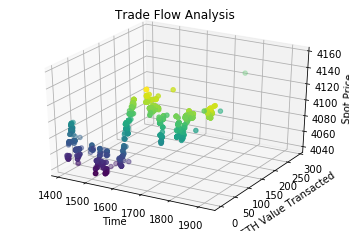

In [54]:
Main()